# Filter snowlines using monthly median and IQR of full timeseries

In [1]:
# import packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import iqr
from time import mktime
import seaborn as sns
from scipy.stats import median_abs_deviation as mad

##### MODIFY HERE #####
# path to glacier-snow-cover-mapping
base_path = r'C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP'
# specify site name
site_name = 'White'
# path where figures will be saved
figures_out_path = os.path.join(base_path, 'study-sites', site_name, 'figure')
# path to snowline files
sl_est_path = os.path.join(base_path, 'study-sites', site_name, 'snow_cover_stats')
# path where filtered snowlines will be saved
out_path = sl_est_path 
# path to USGS mass balance data/ELA csvs 
# If no USGS files, set usgs_path=None
usgs_path = None #'/Users/raineyaberle/Google Drive/My Drive/Research/PhD/GIS_data/USGS/benchmarkGlacier_massBalance/'
#######################

### Stack observations by month, filter points using the monthly distribution

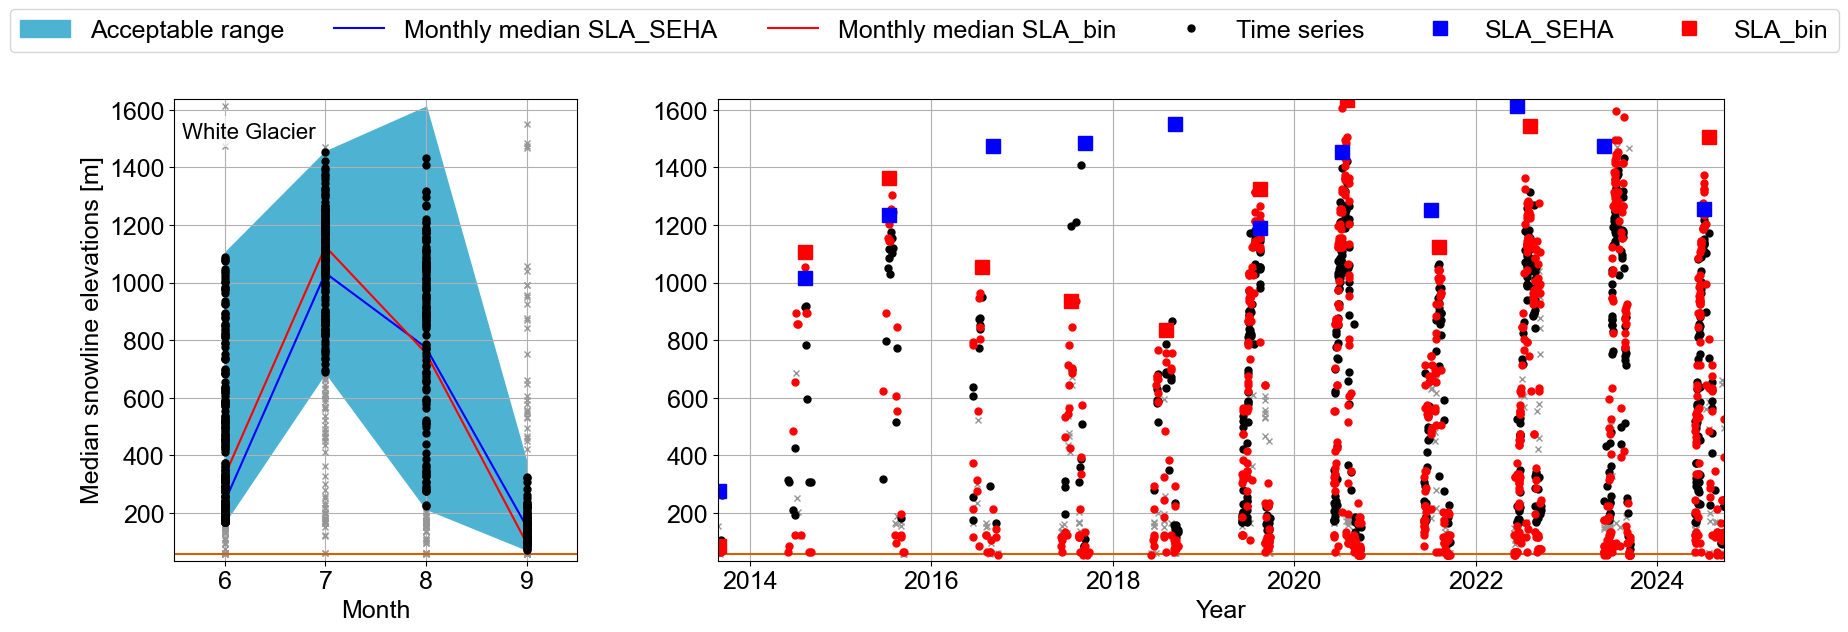

Number of removed points = 250
figure saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\study-sites\White\figure20130823_20240929_White_filtered_snowlines_automated.png
Snowlines saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\study-sites\White\snow_cover_stats20130823_20240929_White_filtered_snowlines.csv
Annual combined ELA and SLA saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\study-sites\White\snow_cover_stats20130823_20240929_White_annual.csv


In [2]:
# -----Compile snowline files
sl_est_fns = glob.glob(os.path.join(sl_est_path, '*snow_cover_stats.csv'))
# compile all snowline files into one DataFrame
sl_est_full = pd.DataFrame()
for fn in sl_est_fns:
    # read file
    if 'csv' in fn:
        sl_est = pd.read_csv(fn)
    elif 'pkl' in fn:
        sl_est = pickle.load(open(fn, 'rb'))
    # concatenate to df
    sl_est_full = pd.concat([sl_est_full, sl_est])
sl_est_full = sl_est_full.reset_index(drop=True).sort_values(by=['datetime'])  # renumber, sort by date

# -----Reformat snowlines dataframes
# unify datetime datatypes
sl_est_full['datetime'] = sl_est_full['datetime'].astype('datetime64[ns]')
# add month column
sl_est_full['month'] = [x.month for x in sl_est_full['datetime']]
# extract all unique months
months = np.unique(sl_est_full['month'])
# set datetime as index
sl_est_full.index = sl_est_full['datetime']

sl_est_full_filt = sl_est_full.copy()


# ----Set up figure
fig = plt.figure(figsize=(20, 6))
plt.rcParams.update({'font.size': 18, 'font.sans-serif': 'Arial'})
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 2.5])
ax1 = fig.add_subplot(spec[0, 0])
ax1.set_xlabel('Month')
ax1.set_ylabel('Median snowline elevations [m]')
ax1.grid()
ax2 = fig.add_subplot(spec[0, 1])
ax2.set_xlabel('Year')
ax2.grid()

# -----Compute monthly medians and IQR ranges (for plotting acceptable range)
med = np.array([np.nanmedian(sl_est_full.loc[sl_est_full['month'] == month]['snowline_elevs_median_m'])
                for month in months])
med_sla = np.array([np.nanmedian(sl_est_full.loc[sl_est_full['month'] == month]['SLA_bin_method_m'])
                    for month in months])
IQR_min = np.array([iqr(sl_est_full.loc[sl_est_full['month'] == month]['snowline_elevs_median_m'],
                        rng=(25, 50), nan_policy='omit')
                    for month in months])
IQR_min[IQR_min < np.nanmin(sl_est_full['snowline_elevs_median_m'])] = np.nanmin(sl_est_full['snowline_elevs_median_m'])
IQR_max = np.array([iqr(sl_est_full.loc[sl_est_full['month'] == month]['snowline_elevs_median_m'],
                        rng=(50, 75), nan_policy='omit') * 3
                    for month in months])
IQR_max[IQR_max == IQR_min] = (np.nanmax(sl_est_full['snowline_elevs_median_m']) -
                               np.nanmin(sl_est_full['snowline_elevs_median_m'])) * 0.1

# -----Remove outliers
# remove points outside of IQR range
n_filt = 0  # No points removed
for j, month in enumerate(months):
    Ifilt = np.ravel(np.argwhere((sl_est_full.loc[sl_est_full['month']==month]['snowline_elevs_median_m'] > med[j]+IQR_max[j]).values |
                    ((sl_est_full.loc[sl_est_full['month']==month]['snowline_elevs_median_m'] < med[j]-IQR_min[j]).values)))
    n_filt = n_filt + len(Ifilt)
    if len(Ifilt)>0:
        sl_est_full_filt = sl_est_full_filt.mask((sl_est_full_filt['month']==month) & (sl_est_full_filt['snowline_elevs_median_m'] > med[j]+IQR_max[j]))
        sl_est_full_filt = sl_est_full_filt.mask((sl_est_full_filt['month']==month) & (sl_est_full_filt['snowline_elevs_median_m'] < med[j]-IQR_min[j]))

    # removed points
    ax1.plot(sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['month'],
             sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['snowline_elevs_median_m'],
             'x', markersize=5, color='#969696', label='_nolegend_')
    ax2.plot(sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['datetime'],
             sl_est_full.loc[sl_est_full['month']==month].iloc[Ifilt]['snowline_elevs_median_m'],
             'x', markersize=5, color='#969696')

# -----Determine annual ELA, SLA, AAR_SLA using the full dataset
# Add years column
sl_est_full['year'] = [x.year for x in sl_est_full['datetime']]
years = np.unique(sl_est_full['year'].dropna())

# Initialize DataFrames
ELAs_df = pd.DataFrame()
# loop through years, save maximum median snowline elevation and date of observation
for year in years:
    sl_est_year = sl_est_full.loc[sl_est_full['year']==year]
    ELA_m, datetime_ELA, ELA_AAR, ELA_SCA_m2, sensor_ELA = sl_est_year.loc[sl_est_year['snowline_elevs_median_m']==np.max(sl_est_year['snowline_elevs_median_m'])][['snowline_elevs_median_m', 'datetime', 'AAR' ,'SCA_m2', 'dataset']].values[0]
    df = pd.DataFrame({'ELA_m': ELA_m,
                       'datetime_ELA':datetime_ELA,
                       'ELA_AAR':ELA_AAR,
                       'ELA_SCA_m2':ELA_SCA_m2,
                       'sensor_ELA':sensor_ELA,
                       'year': year}, index=[0])
    ELAs_df = pd.concat([ELAs_df, df])
ELAs_df = ELAs_df.reset_index(drop=True)

# Initialize DataFrames
SLAs_df = pd.DataFrame()
# loop through years, save maximum SLA_bin_method_m and date of observation
for year in years:
    sl_est_year = sl_est_full.loc[sl_est_full['year']==year]
    SLA_m, datetime_SLA, SLA_AAR, SLA_SCA_m2, sensor_SLA = sl_est_year.loc[sl_est_year['SLA_bin_method_m']==np.max(sl_est_year['SLA_bin_method_m'])][['SLA_bin_method_m', 'datetime', 'AAR' ,'SCA_m2', 'dataset']].values[0]
    df = pd.DataFrame({'SLA_m': SLA_m,
                       'datetime_SLA':datetime_SLA,
                       'SLA_AAR': SLA_AAR,
                       'SLA_SCA_m2': SLA_SCA_m2,
                       'sensor_SLA': sensor_SLA,
                       'year': year}, index=[0])
    SLAs_df = pd.concat([SLAs_df, df])
SLAs_df = SLAs_df.reset_index(drop=True)

# Initialize DataFrames
AAR_ELAs_df = pd.DataFrame()
# loop through years, save maximum AAR_ELA_method_m and date of observation
for year in years:
    sl_est_year = sl_est_full.loc[sl_est_full['year']==year]
    AAR_m, datetime_AAR, AAR_AAR, AAR_SCA_m2, sensor_AAR = sl_est_year.loc[sl_est_year['ELA_from_AAR_m']==np.max(sl_est_year['ELA_from_AAR_m'])][['ELA_from_AAR_m', 'datetime', 'AAR' ,'SCA_m2', 'dataset']].values[0]
    df = pd.DataFrame({'AAR_m': AAR_m,
                       'datetime_AAR': datetime_AAR,
                       'AAR_AAR': AAR_AAR,
                       'AAR_SCA_m2': AAR_SCA_m2,
                       'sensor_AAR': sensor_AAR,
                       'year': year}, index=[0])
    AAR_ELAs_df = pd.concat([AAR_ELAs_df, df])
AAR_ELAs_df = AAR_ELAs_df.reset_index(drop=True)

# -----Plot
ax1.set_xlim(np.min(months) - 0.5, np.max(months) + 0.5)
ax2.set_xlim(np.nanmin(sl_est_full['datetime']), np.nanmax(sl_est_full['datetime']))
# plot minimum elevation
elev_min = np.nanmin(sl_est_full['snowline_elevs_median_m'])
ax1.plot([ax1.get_xlim()[0], ax1.get_xlim()[1]],
         [elev_min, elev_min], '-', color='#d95f02', label='_nolegend_')
ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]],
         [elev_min, elev_min], '-', color='#d95f02', label='_nolegend_')
# range of acceptable values (for visual reference)
ax1.fill_between(months, med - IQR_min, med + IQR_max, color='#4eb3d3', label='Acceptable range')
# monthly median lines
ax1.plot(months, med, '-b', label='Monthly median')
ax1.plot(months, med_sla, '-r', label='Monthly median SLA_bin')
# plot full time series (all points)
ax1.plot(sl_est_full_filt['month'], sl_est_full_filt['snowline_elevs_median_m'], '.k', markersize=10, label='Time series')
ax2.plot(sl_est_full_filt['datetime'], sl_est_full_filt['snowline_elevs_median_m'], '.k', markersize=10)
ax2.plot(sl_est_full['datetime'], sl_est_full['SLA_bin_method_m'], '.r', markersize=10, label='SLA_bin time series')

# ELAs and SLAs markers
ax2.plot(ELAs_df['datetime_ELA'], ELAs_df['ELA_m'], 's', color='b', markersize=10)
ax2.plot(SLAs_df['datetime_SLA'], SLAs_df['SLA_m'], 's', color='r', markersize=10)
ax1.plot(0, 0, 'x', markersize=5, color='#969696', label='Removed points')
ax1.plot(0, 0,  's', color='b', markersize=10, label='SLA_SEHA')

ax1.plot(0, 0, 's', markersize=10, color='b', label='SLA_SEHA')
ax1.text(0.02, 0.95, site_name + ' Glacier', transform=ax1.transAxes,
         fontsize=16, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# set axis limits
ax1.set_xticks(np.linspace(months[0], months[-1], num=months[-1]-months[0]+1))
ax1.set_xlim(np.min(months)-0.5, np.max(months)+0.5)
ax2.set_xlim(np.nanmin(sl_est_full['datetime']), np.nanmax(sl_est_full['datetime']))
ymin, ymax = (np.nanmin(np.concatenate([sl_est_full['snowline_elevs_median_m'].values, np.array(med-IQR_min)]))-25,
              np.nanmax(np.concatenate([sl_est_full['snowline_elevs_median_m'].values, np.array(med+IQR_max)]))+25)
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

# add legend to figure
acceptable_range = mpatches.Patch(color='#4eb3d3', label='Acceptable range')
monthly_median_ela = mlines.Line2D([], [], color='b', label='Monthly median SLA_SEHA')
monthly_median_sla = mlines.Line2D([], [], color='r', label='Monthly median SLA_bin')
filtered_ts = mlines.Line2D([], [], color='k', marker='.', linestyle='None', markersize=10, label='Time series')
ela_marker = mlines.Line2D([], [], color='b', marker='s', linestyle='None', markersize=10, label='SLA_SEHA')
annual_max_sla_marker = mlines.Line2D([], [], color='r', marker='s', linestyle='None', markersize=10, label='SLA_bin')

handles = [
    acceptable_range,
    monthly_median_ela,
    monthly_median_sla,
    filtered_ts,
    ela_marker,
    annual_max_sla_marker
]

fig.legend(handles=handles, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.05))

plt.show()
print('Number of removed points = ' + str(n_filt))


# -----Save figure
min_date = str(np.nanmin(sl_est_full['datetime']))[0:10].replace('-', '')
max_date = str(np.nanmax(sl_est_full['datetime']))[0:10].replace('-', '')
fig_fn = figures_out_path + min_date + '_' + max_date + '_' + site_name + '_filtered_snowlines_automated.png'
fig.savefig(fig_fn, dpi=300, facecolor='w')
print('figure saved to file: ' + fig_fn)

# -----Save full snowline time series (not filtered)
sl_fn = min_date + '_' + max_date + '_' + site_name + '_filtered_snowlines.csv'
# Drop columns if needed; here we keep all points
sl_est_full.to_csv(out_path + sl_fn, index=False)
print('Snowlines saved to file: ' + out_path + sl_fn)

# -----Save ELA, SLA, AAR_SLA time series
annual_combined = pd.merge(ELAs_df, SLAs_df, on='year', how='outer', suffixes=('_ELA', '_SLA'))
annual_combined = pd.merge(annual_combined, AAR_ELAs_df, on='year', how='outer')

annual_combined = annual_combined[[
    'year',
    'datetime_ELA', 'ELA_m', 'ELA_AAR', 'ELA_SCA_m2', 'sensor_ELA',
    'datetime_SLA', 'SLA_m', 'SLA_AAR', 'SLA_SCA_m2', 'sensor_SLA',
    'datetime_AAR', 'AAR_m', 'AAR_AAR', 'AAR_SCA_m2', 'sensor_AAR'
]]

# ----- Optional: Rename AAR-derived columns if desired to avoid confusion
annual_combined.rename(columns={
    'datetime': 'datetime_AAR'
}, inplace=True)

annual_fn = min_date + '_' + max_date + '_' + site_name + '_annual.csv'
annual_combined.to_csv(out_path + annual_fn, index=False)
print('Annual combined ELA and SLA saved to file: ' + out_path + annual_fn)

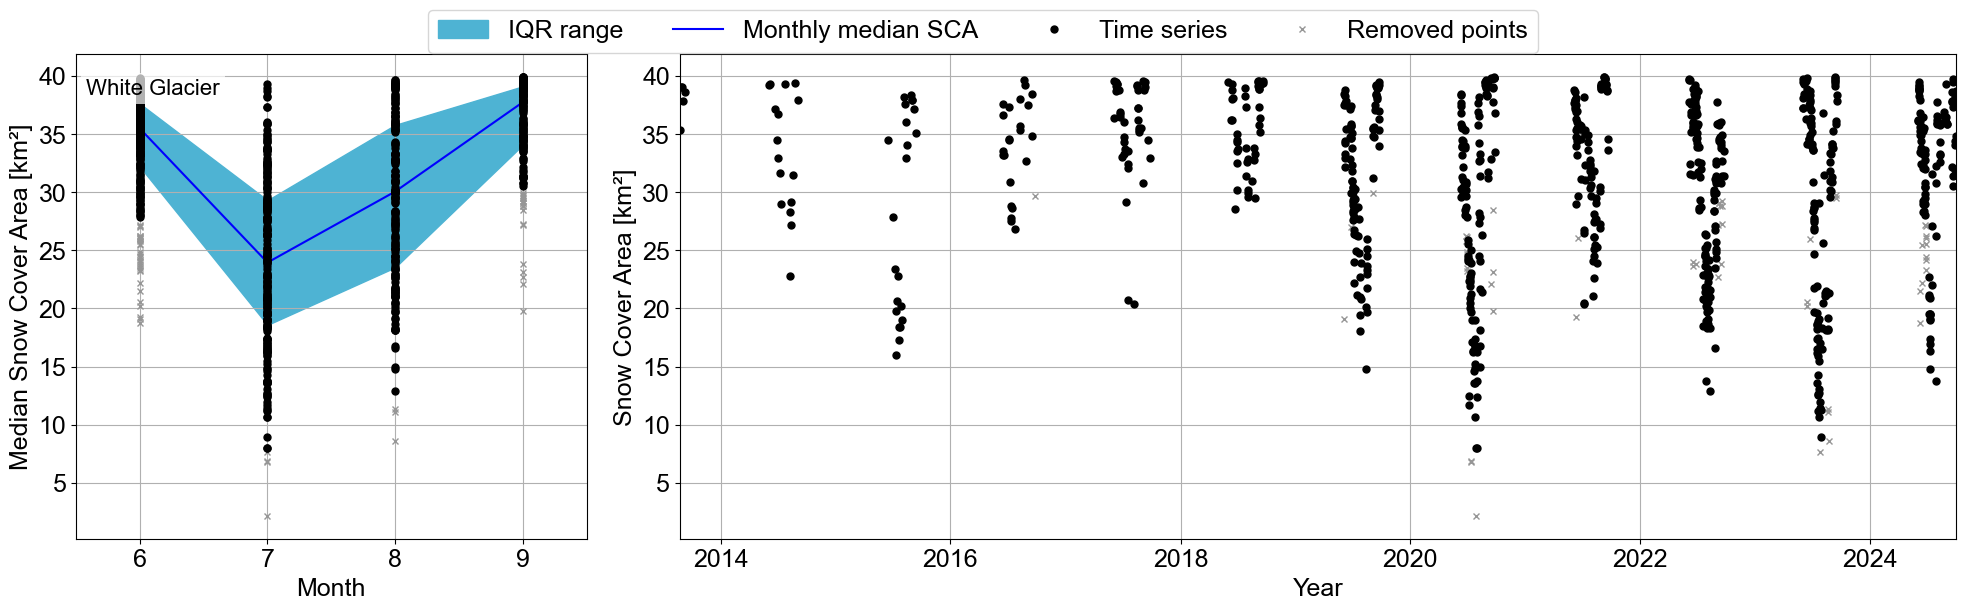

Figure saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\study-sites\White\figure20130823_20240929_White_SCA_km2_plots.png
Number of removed points = 54


In [3]:
# -----Compile snowline files
sl_est_fns = glob.glob(os.path.join(sl_est_path, '*snow_cover_stats.csv'))
sl_est_full = pd.DataFrame()
for fn in sl_est_fns:
    if 'csv' in fn:
        sl_est = pd.read_csv(fn)
    elif 'pkl' in fn:
        sl_est = pickle.load(open(fn, 'rb'))
    sl_est_full = pd.concat([sl_est_full, sl_est])
sl_est_full = sl_est_full.reset_index(drop=True).sort_values(by=['datetime'])

# -----Reformat snowlines dataframes and convert SCA_m2 to SCA_km2
sl_est_full['datetime'] = sl_est_full['datetime'].astype('datetime64[ns]')
sl_est_full['month'] = [x.month for x in sl_est_full['datetime']]
sl_est_full['SCA_km2'] = sl_est_full['SCA_m2'] / 1_000_000  # Convert m² to km²
months = np.unique(sl_est_full['month'])
sl_est_full.index = sl_est_full['datetime']

# ----Set up figure
fig = plt.figure(figsize=(20, 6))
plt.rcParams.update({'font.size': 18, 'font.sans-serif': 'Arial'})
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 2.5])
ax1 = fig.add_subplot(spec[0, 0])
ax1.set_xlabel('Month')
ax1.set_ylabel('Median Snow Cover Area [km²]')
ax1.grid()
ax2 = fig.add_subplot(spec[0, 1])
ax2.set_xlabel('Year')
ax2.set_ylabel('Snow Cover Area [km²]')
ax2.grid()

# -----Compute monthly medians and IQR ranges for SCA_km2
med_sca = np.array([np.nanmedian(sl_est_full.loc[sl_est_full['month'] == month]['SCA_km2'])
                    for month in months])
IQR_min_sca = np.array([np.percentile(sl_est_full.loc[sl_est_full['month'] == month]['SCA_km2'].dropna(), 25)
                        for month in months])
IQR_max_sca = np.array([np.percentile(sl_est_full.loc[sl_est_full['month'] == month]['SCA_km2'].dropna(), 75)
                        for month in months])

# Filter outliers based on IQR (optional, similar to original code)
sl_est_full_filt = sl_est_full.copy()
n_filt = 0
for j, month in enumerate(months):
    Ifilt = np.ravel(np.argwhere((sl_est_full.loc[sl_est_full['month'] == month]['SCA_km2'] > med_sca[j] + 1.5 * (IQR_max_sca[j] - IQR_min_sca[j])).values |
                                 (sl_est_full.loc[sl_est_full['month'] == month]['SCA_km2'] < med_sca[j] - 1.5 * (IQR_max_sca[j] - IQR_min_sca[j])).values))
    n_filt += len(Ifilt)
    if len(Ifilt) > 0:
        sl_est_full_filt = sl_est_full_filt.mask((sl_est_full_filt['month'] == month) & 
                                                 ((sl_est_full_filt['SCA_km2'] > med_sca[j] + 1.5 * (IQR_max_sca[j] - IQR_min_sca[j])) |
                                                  (sl_est_full_filt['SCA_km2'] < med_sca[j] - 1.5 * (IQR_max_sca[j] - IQR_min_sca[j]))))
    
    # Plot removed points
    ax1.plot(sl_est_full.loc[sl_est_full['month'] == month].iloc[Ifilt]['month'],
             sl_est_full.loc[sl_est_full['month'] == month].iloc[Ifilt]['SCA_km2'],
             'x', markersize=5, color='#969696', label='_nolegend_')
    ax2.plot(sl_est_full.loc[sl_est_full['month'] == month].iloc[Ifilt]['datetime'],
             sl_est_full.loc[sl_est_full['month'] == month].iloc[Ifilt]['SCA_km2'],
             'x', markersize=5, color='#969696')

# -----Plot Figure 1: Median Snow Cover Area by Month (in km²)
ax1.set_xlim(np.min(months) - 0.5, np.max(months) + 0.5)
ax1.fill_between(months, IQR_min_sca, IQR_max_sca, color='#4eb3d3', label='IQR range')
ax1.plot(months, med_sca, '-b', label='Monthly median SCA')
ax1.plot(sl_est_full_filt['month'], sl_est_full_filt['SCA_km2'], '.k', markersize=10, label='Time series')

# -----Plot Figure 2: Snow Cover Area Time Series (in km²)
ax2.set_xlim(np.nanmin(sl_est_full['datetime']), np.nanmax(sl_est_full['datetime']))
ax2.plot(sl_est_full_filt['datetime'], sl_est_full_filt['SCA_km2'], '.k', markersize=10, label='SCA time series')

# -----Set axis limits
ymin_sca = np.nanmin([sl_est_full['SCA_km2'].min(), IQR_min_sca.min()]) - 0.05 * np.nanmax(sl_est_full['SCA_km2'])
ymax_sca = np.nanmax([sl_est_full['SCA_km2'].max(), IQR_max_sca.max()]) + 0.05 * np.nanmax(sl_est_full['SCA_km2'])
ax1.set_ylim(ymin_sca, ymax_sca)
ax2.set_ylim(ymin_sca, ymax_sca)
ax1.set_xticks(np.linspace(months[0], months[-1], num=months[-1] - months[0] + 1))

# -----Add legend
handles = [
    mpatches.Patch(color='#4eb3d3', label='IQR range'),
    mlines.Line2D([], [], color='b', label='Monthly median SCA'),
    mlines.Line2D([], [], color='k', marker='.', linestyle='None', markersize=10, label='Time series'),
    mlines.Line2D([], [], color='#969696', marker='x', linestyle='None', markersize=5, label='Removed points')
]
fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05))

# -----Add title
ax1.text(0.02, 0.95, site_name + ' Glacier', transform=ax1.transAxes,
         fontsize=16, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.tight_layout()
plt.show()

# -----Save figure
min_date = str(np.nanmin(sl_est_full['datetime']))[0:10].replace('-', '')
max_date = str(np.nanmax(sl_est_full['datetime']))[0:10].replace('-', '')
fig_fn = figures_out_path + min_date + '_' + max_date + '_' + site_name + '_SCA_km2_plots.png'
fig.savefig(fig_fn, dpi=300, facecolor='w')
print('Figure saved to file: ' + fig_fn)
print('Number of removed points = ' + str(n_filt))

In [4]:
£$"£$234"

SyntaxError: invalid character '£' (U+00A3) (40152077.py, line 1)

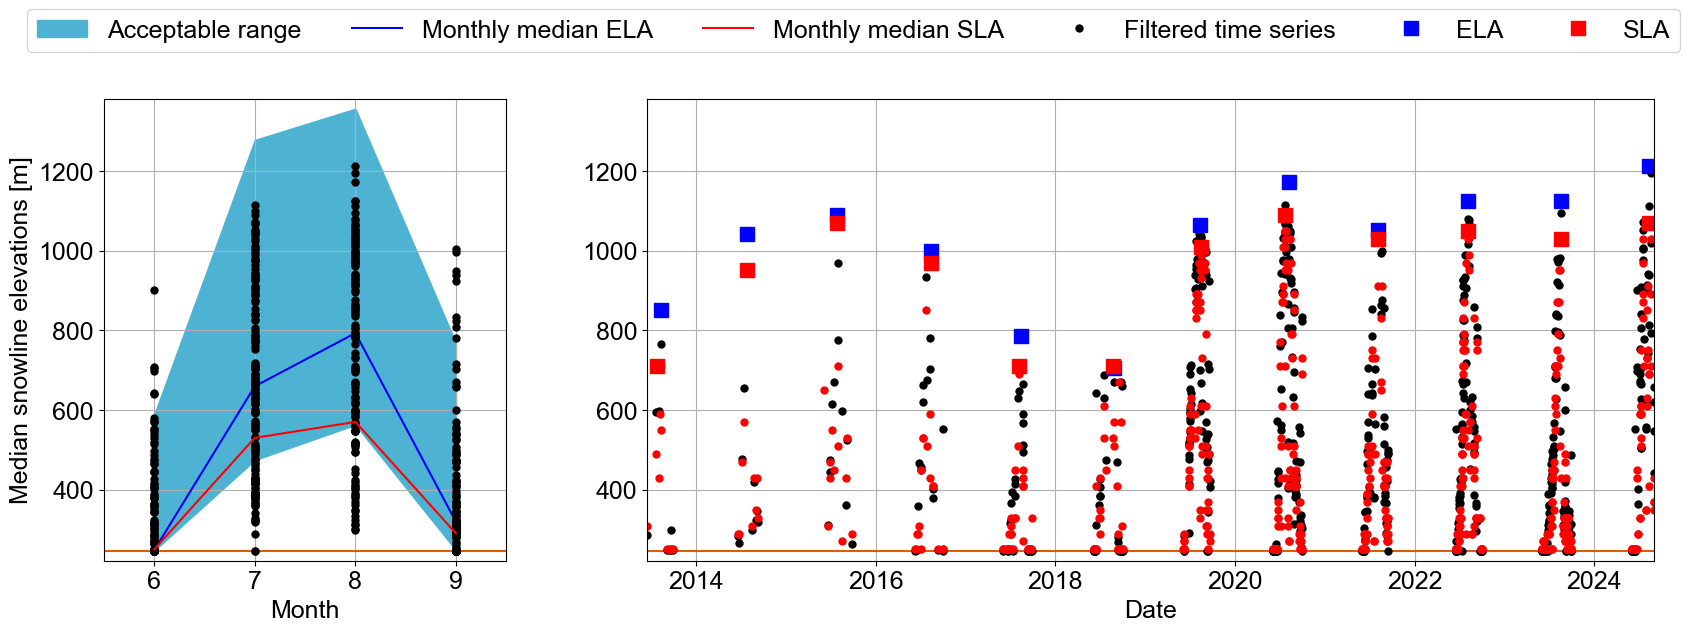

Number of removed points = 73
figure saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\study-sites\Fountain\figure20130615_20240830_Fountain_snowlines_automated.png
filtered snowlines saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\study-sites\Fountain\snow_cover_stats20130615_20240830_Fountain_snowlines.csv
Annual combined ELA and SLA saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\study-sites\Fountain\snow_cover_stats20130615_20240830_Fountain_annual.csv
 


In [ ]:
# -----Compile snowline files
sl_est_fns = glob.glob(os.path.join(sl_est_path, '*snow_cover_stats.csv'))
# compile all snowline files into one DataFrame
sl_est_full = pd.DataFrame()
for fn in sl_est_fns:
    # read file
    if 'csv' in fn:
        sl_est = pd.read_csv(fn)
    elif 'pkl' in fn:
        sl_est = pickle.load(open(fn, 'rb'))
    # concatenate to df
    sl_est_full = pd.concat([sl_est_full, sl_est])
sl_est_full = sl_est_full.reset_index(drop=True).sort_values(by=['datetime']) # renumber, sort by date

# -----Reformat snowlines dataframes
# unify datetime datatypes
sl_est_full['datetime'] = sl_est_full['datetime'].astype('datetime64[ns]')
# add month column
sl_est_full['month'] = [x.month for x in sl_est_full['datetime']]
# extract all unique months
months = np.unique(sl_est_full['month'])
# set datetime as index
sl_est_full.index = sl_est_full['datetime']

# ----Set up figure
fig = plt.figure(figsize=(20, 6))
plt.rcParams.update({'font.size':18, 'font.sans-serif':'Arial'})
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 2.5])
ax1 = fig.add_subplot(spec[0, 0])
ax1.set_xlabel('Month')
ax1.set_ylabel('Median snowline elevations [m]')
ax1.grid()
ax2 = fig.add_subplot(spec[0, 1])
ax2.set_xlabel('Date')
ax2.grid()

# -----Filter points using median and IQR trend
med = np.array([np.nanmedian(sl_est_full.loc[sl_est_full['month']==month]['snowline_elevs_median_m']) for month in months]) # ELA
med_sla = np.array([np.nanmedian(sl_est_full.loc[sl_est_full['month'] == month]['SLA_bin_method_m']) for month in months]) # SLA
# mean = np.array([np.nanmean(sl_est_full.loc[sl_est_full['month']==month]['snowline_elevs_median_m']) for month in months])
# std = np.array([np.nanstd(sl_est_full.loc[sl_est_full['month']==month]['snowline_elevs_median_m']) for month in months])
# MAD = np.array([mad(sl_est_full.loc[sl_est_full['month']==month]['snowline_elevs_median_m'], nan_policy='omit') for month in months])
IQR_min = np.array([iqr(sl_est_full.loc[sl_est_full['month']==month]['snowline_elevs_median_m'],
                        rng=(25,50), nan_policy='omit') for month in months])
# if minimum goes below the glacier elevation range, make it the minimum elevation
IQR_min[IQR_min < np.nanmin(sl_est_full['snowline_elevs_median_m'])]== np.nanmin(sl_est_full['snowline_elevs_median_m'])
IQR_max = np.array([iqr(sl_est_full.loc[sl_est_full['month']==month]['snowline_elevs_median_m'],
                        rng=(50,75), nan_policy='omit')*3 for month in months])
# if the IQR_max = IQR_min, increase the max value by 10% the elevation range
IQR_max[IQR_max==IQR_min] = (np.nanmax(sl_est_full['snowline_elevs_median_m']) - np.nanmin(sl_est_full['snowline_elevs_median_m']))*0.1



# -----Determine annual ELAs
sl_est_full_filt = sl_est_full.copy()
# add years column
sl_est_full_filt['year'] = [x.year for x in sl_est_full_filt['datetime']]
# grab all unique years
years = np.unique(sl_est_full_filt['year'].dropna())
# initialize dataframe for ELAs
ELAs_df = pd.DataFrame()
# loop through years, save maximum median snowline elevation and date of observation
for year in years:
    sl_est_year = sl_est_full_filt.loc[sl_est_full_filt['year']==year]
    ELA, dt = sl_est_year.loc[sl_est_year['snowline_elevs_median_m']==np.max(sl_est_year['snowline_elevs_median_m'])][['snowline_elevs_median_m', 'datetime']].values[0]
    df = pd.DataFrame({
        'year': [year],
        'ELA_m': [ELA],
        'datetime': [dt]
    })
    ELAs_df = pd.concat([ELAs_df, df], ignore_index=True)

# ----Determine annual SLA
sl_est_full_filt['year'] = [x.year for x in sl_est_full_filt['datetime']]
years = np.unique(sl_est_full_filt['year'].dropna())
SLAs_df = pd.DataFrame()
for year in years:
    sl_est_year = sl_est_full_filt.loc[sl_est_full_filt['year'] == year]
    # Identify the row(s) with the maximum bin_SLA
    SLA, dt = sl_est_year.loc[
        sl_est_year['SLA_bin_method_m'] == np.max(sl_est_year['SLA_bin_method_m'])
    ][['SLA_bin_method_m', 'datetime']].values[0]
    df = pd.DataFrame({
        'year': [year],
        'SLA_m': [SLA],
        'datetime': [dt]
    })
    SLAs_df = pd.concat([SLAs_df, df], ignore_index=True)


# -----Plot
ax1.set_xlim(np.min(months)-0.5, np.max(months)+0.5)
ax2.set_xlim(np.nanmin(sl_est_full['datetime']), np.nanmax(sl_est_full['datetime']))
# plot minimum elevation
elev_min = np.nanmin(sl_est_full['snowline_elevs_median_m'])
ax1.plot([ax1.get_xlim()[0], ax1.get_xlim()[1]],
         [elev_min, elev_min], '-', color='#d95f02', label='_nolegend_')
ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]],
         [elev_min, elev_min], '-', color='#d95f02', label='_nolegend_')
# range of acceptable values
ax1.fill_between(months, med-IQR_min, med+IQR_max, color='#4eb3d3', label='Acceptable range')
# monthly median
ax1.plot(months, med, '-b', label='Monthly median')
# filtered time series
ax1.plot(sl_est_full_filt['month'], sl_est_full_filt['snowline_elevs_median_m'], '.k', markersize=10, label='Filtered time series')
ax2.plot(sl_est_full_filt['datetime'], sl_est_full_filt['snowline_elevs_median_m'], '.k', markersize=10)

# -----Add new plot for median bin SLA-----
ax1.plot(months, med_sla, '-r', label='Monthly median SLA')
ax2.plot(sl_est_full['datetime'], sl_est_full['SLA_bin_method_m'], '.r', markersize=10, label='SLA time series')

# ELAs
ax2.plot(ELAs_df['datetime'], ELAs_df['ELA_m'], 's', color='b', markersize=10)
# ELAs
ax2.plot(SLAs_df['datetime'], SLAs_df['SLA_m'], 's', color='r', markersize=10)

# set axis limits
ax1.set_xticks(np.linspace(months[0], months[-1], num=months[-1]-months[0]+1))
ax1.set_xlim(np.min(months)-0.5, np.max(months)+0.5)
ax2.set_xlim(np.nanmin(sl_est_full['datetime']), np.nanmax(sl_est_full['datetime']))
ymin, ymax = (np.nanmin(np.concatenate([sl_est_full['snowline_elevs_median_m'].values, np.array(med-IQR_min)]))-25,
              np.nanmax(np.concatenate([sl_est_full['snowline_elevs_median_m'].values, np.array(med+IQR_max)]))+25)
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

# add legend to figure
# Define custom handles in the order you want them to appear:
acceptable_range = mpatches.Patch(color='#4eb3d3', label='Acceptable range')
monthly_median_ela = mlines.Line2D([], [], color='b', label='Monthly median ELA')
monthly_median_sla = mlines.Line2D([], [], color='r', label='Monthly median SLA')
filtered_ts = mlines.Line2D([], [], color='k', marker='.', linestyle='None', markersize=10, label='Filtered time series')
ela_marker = mlines.Line2D([], [], color='b', marker='s', linestyle='None', markersize=10, label='ELA')
annual_max_sla_marker = mlines.Line2D([], [], color='r', marker='s', linestyle='None', markersize=10, label='SLA')

# Combine them into a list in your preferred order:
handles = [
    acceptable_range,
    monthly_median_ela,
    monthly_median_sla,
    filtered_ts,
    ela_marker,
    annual_max_sla_marker
]

# Place the legend in one line at the top:
fig.legend(handles=handles, loc='upper center', ncol=7, bbox_to_anchor=(0.5, 1.05))

plt.show()
print('Number of removed points = '+str(n_filt))


# -----Save figure
min_date = str(np.nanmin(sl_est_full['datetime']))[0:10].replace('-','')
max_date = str(np.nanmax(sl_est_full['datetime']))[0:10].replace('-','')
fig_fn = figures_out_path + min_date + '_'+ max_date + '_' + site_name + '_snowlines_automated.png'
fig.savefig(fig_fn, dpi=300, facecolor='w')
print('figure saved to file: ' + fig_fn)

# -----Save filtered snowline time series
sl_fn = min_date + '_' + max_date + '_' + site_name + '_snowlines.csv'
sl_est_full_filt = sl_est_full_filt.dropna().drop(['datetime', 'month'], axis=1)
sl_est_full_filt.to_csv(out_path + sl_fn)
print('filtered snowlines saved to file: ' + out_path + sl_fn)

# -----Save ELA times series
annual_combined = pd.merge(ELAs_df, SLAs_df, on='year', how='outer', suffixes=('_ELA', '_SLA'))
annual_combined = annual_combined[['year', 'datetime_ELA', 'ELA_m', 'datetime_SLA', 'SLA_m']]
annual_fn = min_date + '_' + max_date + '_' + site_name + '_annual.csv'
annual_combined.to_csv(out_path + annual_fn, index=False)
print('Annual combined ELA and SLA saved to file: ' + out_path + annual_fn)

print(' ')